# Session 3 — Sentence-Level Analysis
## Measure 3: Sentence Embeddings (LLMs as Semantic Encoders)
### BONUS: Comparative Analysis of Alice's Adventures in Wonderland and Through the Looking-Glass

> **Note:** This is an **advanced extension** of notebook `3_1_AppliedNLP_Session3_Sentence_Embeddings.ipynb`. 
> Complete the basic notebook first to understand the fundamentals of sentence embeddings before working through this more complex literary analysis.

---

### What This Bonus Notebook Covers
This advanced demonstration applies sentence embeddings to **real literary texts**, analyzing Lewis Carroll's two Alice books:
- Extracts and compares key sentences from both novels
- Performs multi-dimensional visualization (2D, 3D)
- Automatically discovers thematic clusters
- Quantifies cross-book semantic similarities
- Provides comparative literary analysis

### Prerequisites
Before starting this notebook, you should:
- Complete notebook `3_1` and understand basic sentence embeddings
- Be familiar with PCA (Principal Component Analysis)
- Understand cosine similarity metrics
- Have the Alice books in the `../data/` folder

---

### Quick Review: What are Sentence Embeddings?
Sentence embeddings are **dense vector representations** of sentences that capture their semantic meaning in a high-dimensional space. Unlike traditional word-based approaches, sentence embeddings encode the entire meaning of a sentence into a single fixed-length vector (typically 384-768 dimensions).

### How They Work
Modern sentence embedding models (like SBERT - Sentence-BERT) use **transformer architectures** pre-trained on massive text corpora. These models:
- Convert sentences into numerical vectors where semantically similar sentences are close together in vector space
- Capture context, syntax, and semantic relationships
- Enable comparison of sentences based on meaning rather than just word overlap

### Key Applications in NLP
1. **Semantic Similarity**: Measure how similar two sentences are in meaning
2. **Information Retrieval**: Find relevant documents or passages based on semantic search
3. **Text Clustering**: Group similar sentences or documents together
4. **Duplicate Detection**: Identify paraphrases or semantically identical content
5. **Question Answering**: Match questions with relevant answers
6. **Content Recommendation**: Suggest similar content based on semantic understanding
7. **Comparative Literary Analysis**: Compare themes, writing styles, and narrative patterns across texts

### This Advanced Demonstration
We'll use the **all-MiniLM-L6-v2** model to:
- Extract key sentences from both Alice books using extractive summarization
- Encode sentences into semantic vectors
- Visualize thematic relationships between the two books in 2D/3D space
- Identify semantic similarities and differences between the narratives
- Cluster sentences by themes (e.g., size changes, absurdity, dialogue, fantasy)
- Perform quantitative comparative literature analysis

In [6]:
# Import necessary libraries
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import re
import nltk
from collections import Counter

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [7]:
# Load the three LOTR books
def load_book(filepath):
    """Load and clean book text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Remove Project Gutenberg headers/footers (assuming standard format)
    # LOTR books are often formatted differently, so these start/end markers
    # might need adjustment based on your specific files.
    start_markers = ['*** START OF', 'CHAPTER I', 'The Fellowship of the Ring', 'The Two Towers', 'The Return of the King']
    end_markers = ['*** END OF', 'End of Project Gutenberg']
    
    # Find start
    for marker in start_markers:
        if marker in text:
            start = text.find(marker)
            if marker in ['CHAPTER I', 'The Fellowship of the Ring', 'The Two Towers', 'The Return of the King']:
                text = text[start:]
            else:
                text = text[start + len(marker):]
            break
    
    # Find end
    for marker in end_markers:
        if marker in text:
            end = text.find(marker)
            text = text[:end]
            break
    
    return text

# Load all three books
fellowship_text = load_book('../data/Fellowship.txt')
two_towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

print(f"The Fellowship of the Ring: {len(fellowship_text):,} characters")
print(f"The Two Towers: {len(two_towers_text):,} characters")
print(f"The Return of the King: {len(king_text):,} characters")

The Fellowship of the Ring: 999,370 characters
The Two Towers: 834,448 characters
The Return of the King: 709,776 characters


In [11]:
# Extract meaningful sentences from all three books
def extract_key_sentences(text, n_sentences=30):
    """
    Extract key sentences using a simple extractive approach:
    - Filter by length (not too short, not too long)
    - Prefer sentences with dialogue or interesting content
    - Avoid repetitive patterns
    """
    # Split into sentences
    sentences = nltk.sent_tokenize(text)
    
    # Clean and filter sentences
    filtered = []
    for sent in sentences:
        # Remove extra whitespace
        sent = ' '.join(sent.split())
        
        # Filter criteria
        word_count = len(sent.split())
        if word_count < 8 or word_count > 40:  # Not too short or long
            continue
        if sent.startswith('CHAPTER'):  # Skip chapter headers
            continue
        if re.match(r'^[IVX]+\.', sent):  # Skip Roman numerals
            continue
        
        filtered.append(sent)
    
    # Score sentences based on interesting features (THIS SECTION WAS MISSING)
    scores = []
    for sent in filtered:
        score = 0
        
        # Dialogue is interesting
        # Note: This is an attempt to capture quotes, adjusting for common '...' truncation
        if '"' in sent or '“' in sent or '”' in sent:
            score += 2
        
        # Questions are interesting
        if '?' in sent:
            score += 1
        
        # Exclamations add emotion
        if '!' in sent:
            score += 1
        
        # Prefer sentences with key words (e.g., Frodo, Ring, Gandalf)
        if any(word in sent for word in ['Frodo', 'Ring', 'Gandalf', 'Sauron', 'Gollum']):
            score += 1
        
        # Length sweet spot
        word_count = len(sent.split())
        if 12 <= word_count <= 25:
            score += 1
        
        scores.append(score)
    
    # Get top N sentences by score
    scored_sentences = list(zip(filtered, scores))
    scored_sentences.sort(key=lambda x: x[1], reverse=True)
    
    # Return top sentences (without duplicates)
    top_sentences = []
    for sent, score in scored_sentences[:n_sentences * 2]:
        if sent not in top_sentences:
            top_sentences.append(sent)
        if len(top_sentences) >= n_sentences:
            break
    
    return top_sentences

# Extract key sentences from all three books
n_per_book = 25
fellowship_sentences = extract_key_sentences(fellowship_text, n_per_book)
two_towers_sentences = extract_key_sentences(two_towers_text, n_per_book)
king_sentences = extract_key_sentences(king_text, n_per_book)

print(f"Extracted {len(fellowship_sentences)} key sentences from The Fellowship of the Ring")
print(f"Extracted {len(two_towers_sentences)} key sentences from The Two Towers")
print(f"Extracted {len(king_sentences)} key sentences from The Return of the King")
print(f"\nTotal sentences to analyze: {len(fellowship_sentences) + len(two_towers_sentences) + len(king_sentences)}")

# Show a few examples
print("\n" + "="*80)
print("SAMPLE FROM THE FELLOWSHIP OF THE RING:")
print("="*80)
for i, sent in enumerate(fellowship_sentences[:3], 1):
    print(f"{i}. {sent}")

print("\n" + "="*80)
print("SAMPLE FROM THE RETURN OF THE KING:")
print("="*80)
for i, sent in enumerate(king_sentences[:3], 1):
    print(f"{i}. {sent}")

Extracted 25 key sentences from The Fellowship of the Ring
Extracted 25 key sentences from The Two Towers
Extracted 25 key sentences from The Return of the King

Total sentences to analyze: 75

SAMPLE FROM THE FELLOWSHIP OF THE RING:
1. For I am Saruman the Wise, Saruman Ring-maker, Saruman of Many Colours!"
2. "No secrets between us, Frodo," he said; "but they are not to go any further.
3. "For Sauron knows," said he, "that one of these was known to you on a time."

SAMPLE FROM THE RETURN OF THE KING:
1. Ever and anon Gandalf let blow the trumpets, and the heralds would cry: “The Lords of Gondor are come!
2. ‘I suppose so, Mr. Baggins; but we have to say just “the Chief” nowadays.’ ‘Do you indeed!’ said Frodo.
3. Let your wrath at an old man’s folly run off and then return to my comfort!’ ‘Folly?’ said Gandalf.


In [13]:
# Load sentence transformer model and generate embeddings
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine sentences and track their sources
all_sentences = fellowship_sentences + two_towers_sentences + king_sentences
book_labels = ['Fellowship'] * len(fellowship_sentences) + \
              ['Two Towers'] * len(two_towers_sentences) + \
              ['The King'] * len(king_sentences)

# Generate embeddings
print("Generating embeddings...")
embeddings = model.encode(all_sentences, show_progress_bar=True)

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Each sentence → {embeddings.shape[1]}-dimensional vector")

Loading sentence transformer model...
Generating embeddings...


Batches: 100%|██████████| 3/3 [00:00<00:00, 13.99it/s]


Embedding shape: (75, 384)
Each sentence → 384-dimensional vector


In [14]:
# Perform clustering to identify themes
n_clusters = 7 # Increased for larger dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

print(f"Identified {n_clusters} thematic clusters")
print("\nCluster distribution:")
for i in range(n_clusters):
    count = sum(clusters == i)
    fellowship_count = sum((clusters == i) & (np.array(book_labels) == 'Fellowship'))
    two_towers_count = sum((clusters == i) & (np.array(book_labels) == 'Two Towers'))
    king_count = sum((clusters == i) & (np.array(book_labels) == 'The King'))
    print(f"  Cluster {i}: {count} sentences (F:{fellowship_count}, TT:{two_towers_count}, K:{king_count})")

Identified 7 thematic clusters

Cluster distribution:
  Cluster 0: 8 sentences (F:3, TT:4, K:1)
  Cluster 1: 23 sentences (F:3, TT:7, K:13)
  Cluster 2: 14 sentences (F:8, TT:3, K:3)
  Cluster 3: 10 sentences (F:4, TT:5, K:1)
  Cluster 4: 8 sentences (F:2, TT:4, K:2)
  Cluster 5: 2 sentences (F:1, TT:0, K:1)
  Cluster 6: 10 sentences (F:4, TT:2, K:4)


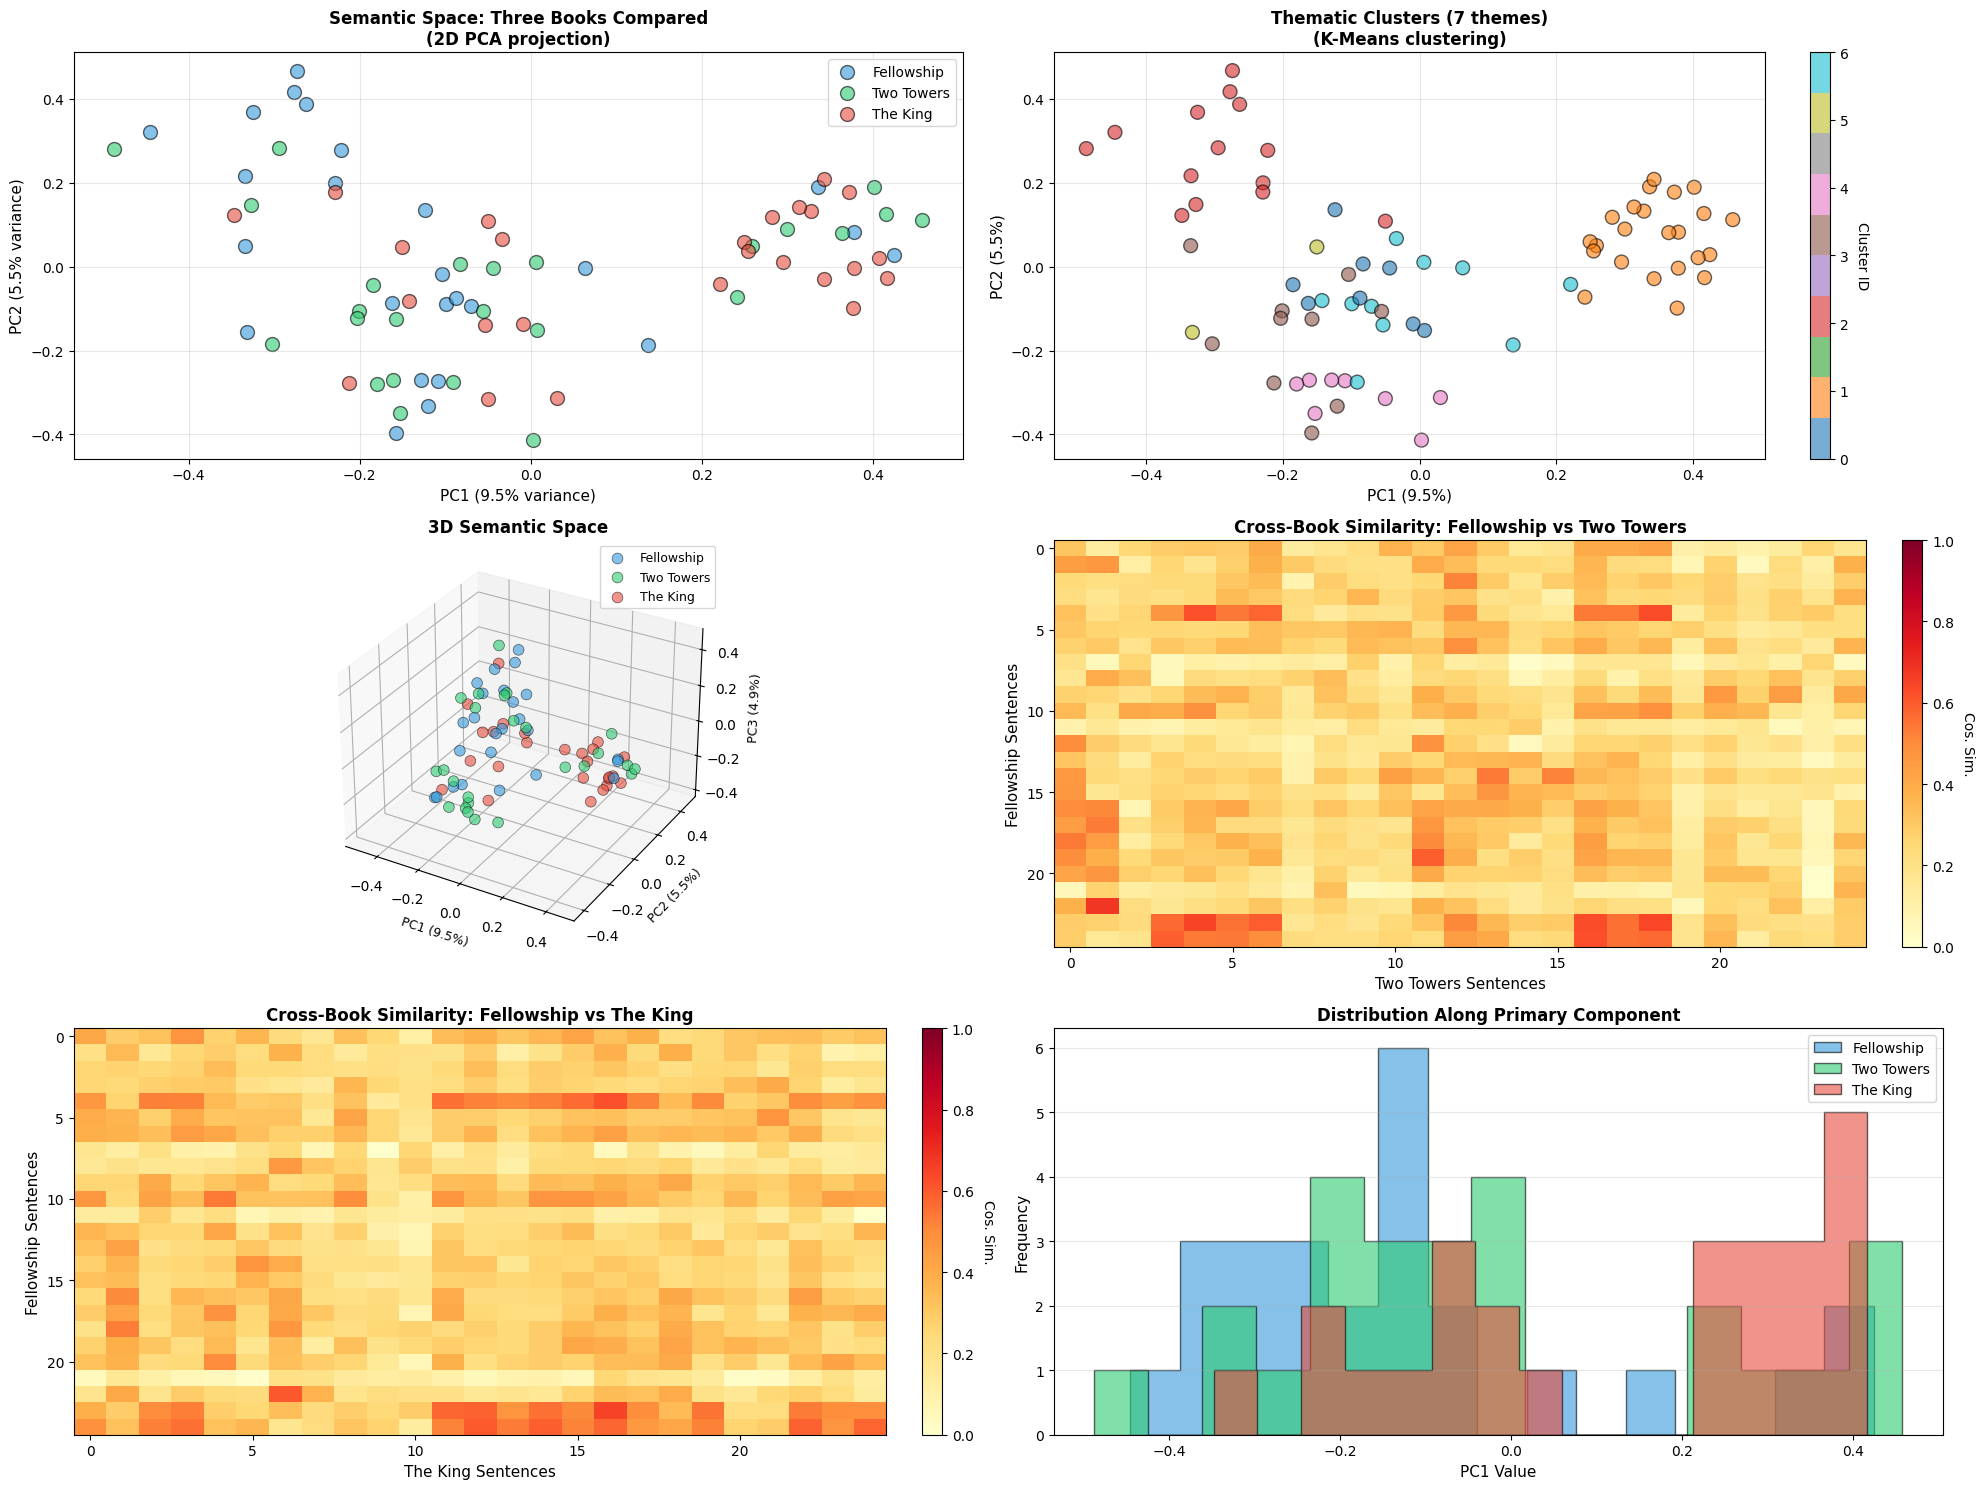

In [15]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15)) # Increased height for better visibility

# Define colors for the three books
colors_dict = {'Fellowship': '#3498db', 'Two Towers': '#2ecc71', 'The King': '#e74c3c'}
book_names = ['Fellowship', 'Two Towers', 'The King']

# --- Plot 1: 2D PCA with book distinction ---
ax1 = plt.subplot(3, 2, 1)
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)

for book in book_names:
    mask = np.array(book_labels) == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
               c=colors_dict[book], label=book, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_title('Semantic Space: Three Books Compared\n(2D PCA projection)', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 2: 2D PCA with clusters ---
ax2 = plt.subplot(3, 2, 2)
scatter = ax2.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax2.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax2.set_title(f'Thematic Clusters ({n_clusters} themes)\n(K-Means clustering)', 
             fontsize=12, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# --- Plot 3: 3D PCA ---
ax3 = plt.subplot(3, 2, 3, projection='3d')
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

for book in book_names:
    mask = np.array(book_labels) == book
    ax3.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
               c=colors_dict[book], label=book, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax3.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=9)
ax3.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=9)
ax3.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=9)
ax3.set_title('3D Semantic Space', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)

# --- Define Embeddings for Pairwise Plots ---
# Assuming 25 sentences per book (0-24, 25-49, 50-74)
F_emb = embeddings[:len(fellowship_sentences)]
TT_emb = embeddings[len(fellowship_sentences):len(fellowship_sentences) + len(two_towers_sentences)]
K_emb = embeddings[len(fellowship_sentences) + len(two_towers_sentences):]

# --- Plot 4: F vs TT Similarity Matrix ---
ax4 = plt.subplot(3, 2, 4)
cross_similarity_ftt = util.cos_sim(F_emb, TT_emb).numpy()

im_ftt = ax4.imshow(cross_similarity_ftt, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im_ftt, ax=ax4, fraction=0.046, pad=0.04).set_label('Cos. Sim.', rotation=270, labelpad=15, fontsize=10)
ax4.set_xlabel('Two Towers Sentences', fontsize=11)
ax4.set_ylabel('Fellowship Sentences', fontsize=11)
ax4.set_title('Cross-Book Similarity: Fellowship vs Two Towers', fontsize=12, fontweight='bold')

# --- Plot 5: F vs K Similarity Matrix ---
ax5 = plt.subplot(3, 2, 5)
cross_similarity_fk = util.cos_sim(F_emb, K_emb).numpy()

im_fk = ax5.imshow(cross_similarity_fk, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im_fk, ax=ax5, fraction=0.046, pad=0.04).set_label('Cos. Sim.', rotation=270, labelpad=15, fontsize=10)
ax5.set_xlabel('The King Sentences', fontsize=11)
ax5.set_ylabel('Fellowship Sentences', fontsize=11)
ax5.set_title('Cross-Book Similarity: Fellowship vs The King', fontsize=12, fontweight='bold')

# --- Plot 6: Distribution histogram (PC1) ---
ax6 = plt.subplot(3, 2, 6)

F_pc1 = points_2d[:len(fellowship_sentences), 0]
TT_pc1 = points_2d[len(fellowship_sentences):len(fellowship_sentences) + len(two_towers_sentences), 0]
K_pc1 = points_2d[len(fellowship_sentences) + len(two_towers_sentences):, 0]

# Use step-filled histogram for better visual separation of three distributions
ax6.hist(F_pc1, bins=15, alpha=0.6, color=colors_dict['Fellowship'], label='Fellowship', edgecolor='black', histtype='stepfilled')
ax6.hist(TT_pc1, bins=15, alpha=0.6, color=colors_dict['Two Towers'], label='Two Towers', edgecolor='black', histtype='stepfilled')
ax6.hist(K_pc1, bins=15, alpha=0.6, color=colors_dict['The King'], label='The King', edgecolor='black', histtype='stepfilled')

ax6.set_xlabel('PC1 Value', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Distribution Along Primary Component', fontsize=12, fontweight='bold')
ax6.legend(loc='best')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

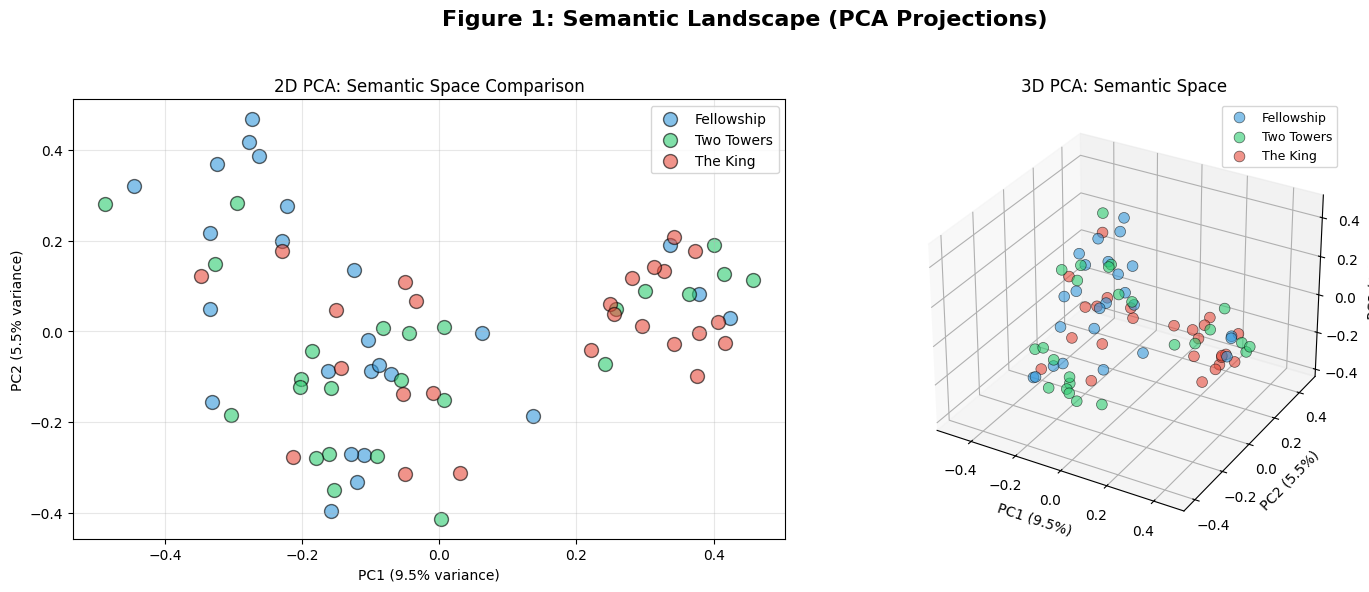

In [19]:
# --- Figure 1: Semantic Landscape (PCA Analysis) ---
fig1 = plt.figure(figsize=(15, 6))
plt.suptitle('Figure 1: Semantic Landscape (PCA Projections)', fontsize=16, fontweight='bold')

# Setup common data
pca_2d = PCA(n_components=2)
points_2d = pca_2d.fit_transform(embeddings)
pca_3d = PCA(n_components=3)
points_3d = pca_3d.fit_transform(embeddings)

# --- Plot 1.1: 2D PCA with Book Distinction ---
ax1 = fig1.add_subplot(1, 2, 1)

for book in book_names:
    mask = np.array(book_labels) == book
    ax1.scatter(points_2d[mask, 0], points_2d[mask, 1], 
               c=colors_dict[book], label=book, alpha=0.6, s=100, edgecolors='black', linewidth=1)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('2D PCA: Semantic Space Comparison')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# --- Plot 1.2: 3D PCA ---
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')

for book in book_names:
    mask = np.array(book_labels) == book
    ax2.scatter(points_3d[mask, 0], points_3d[mask, 1], points_3d[mask, 2],
               c=colors_dict[book], label=book, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax2.set_title('3D PCA: Semantic Space')
ax2.legend(loc='best', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

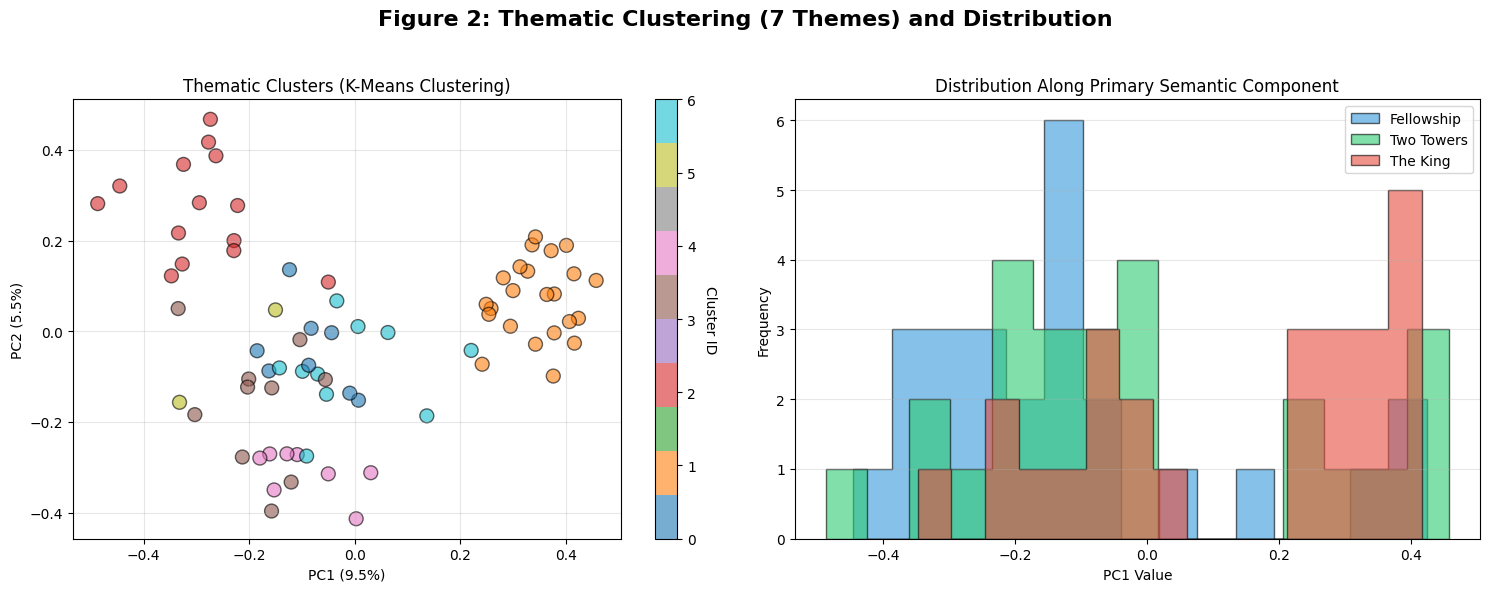

In [20]:
# --- Figure 2: Thematic Focus & Coherence ---
fig2 = plt.figure(figsize=(15, 6))
plt.suptitle(f'Figure 2: Thematic Clustering ({n_clusters} Themes) and Distribution', fontsize=16, fontweight='bold')

# --- Plot 2.1: 2D PCA with Clusters ---
ax1 = fig2.add_subplot(1, 2, 1)

scatter = ax1.scatter(points_2d[:, 0], points_2d[:, 1], c=clusters, 
                     cmap='tab10', alpha=0.6, s=100, edgecolors='black', linewidth=1)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})')
ax1.set_title('Thematic Clusters (K-Means Clustering)')
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Cluster ID', rotation=270, labelpad=15)
ax1.grid(True, alpha=0.3)

# --- Plot 2.2: Distribution histogram (PC1) ---
ax2 = fig2.add_subplot(1, 2, 2)

F_pc1 = points_2d[:len(fellowship_sentences), 0]
TT_pc1 = points_2d[len(fellowship_sentences):len(fellowship_sentences) + len(two_towers_sentences), 0]
K_pc1 = points_2d[len(fellowship_sentences) + len(two_towers_sentences):, 0]

ax2.hist(F_pc1, bins=15, alpha=0.6, color=colors_dict['Fellowship'], label='Fellowship', edgecolor='black', histtype='stepfilled')
ax2.hist(TT_pc1, bins=15, alpha=0.6, color=colors_dict['Two Towers'], label='Two Towers', edgecolor='black', histtype='stepfilled')
ax2.hist(K_pc1, bins=15, alpha=0.6, color=colors_dict['The King'], label='The King', edgecolor='black', histtype='stepfilled')

ax2.set_xlabel('PC1 Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution Along Primary Semantic Component')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

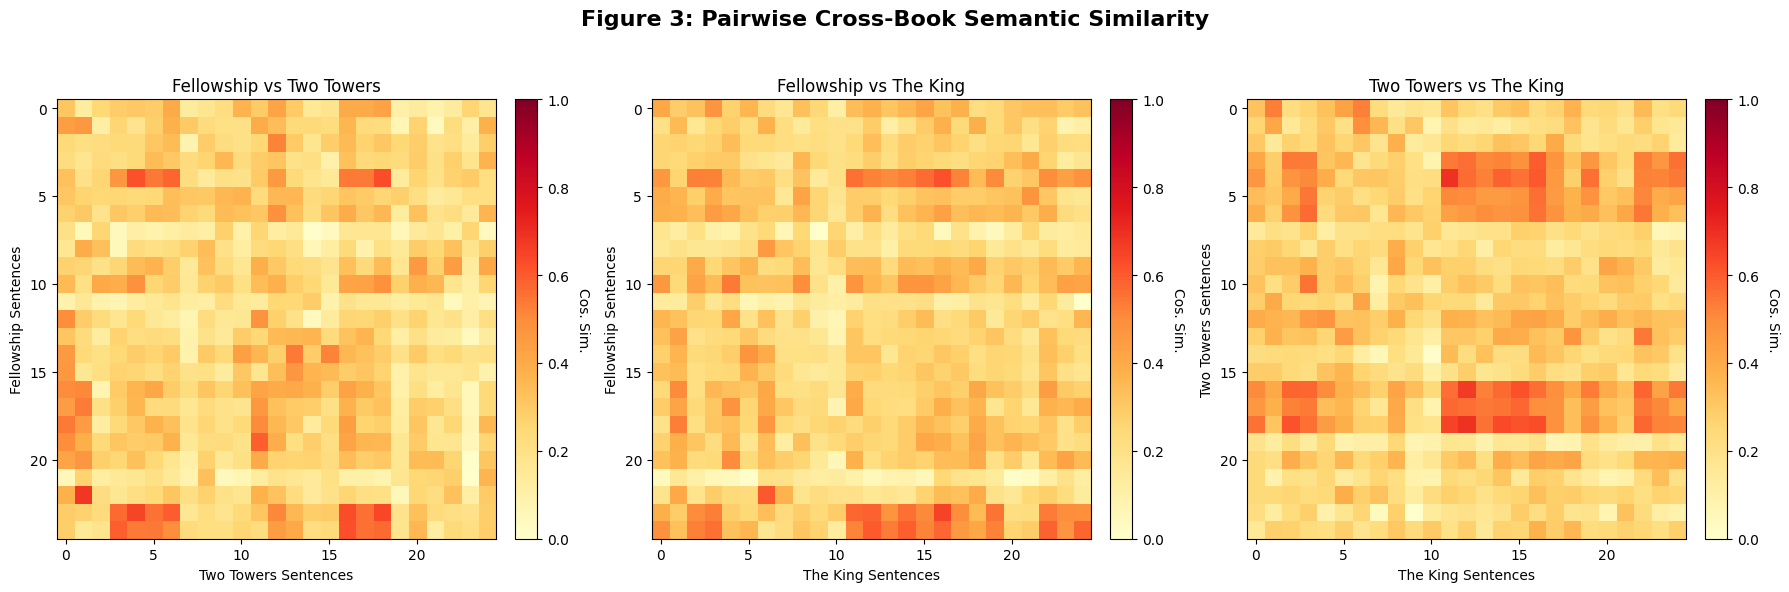

In [21]:
# --- Figure 3: Cross-Book Parallels (Similarity Matrices) ---
fig3 = plt.figure(figsize=(18, 6))
plt.suptitle('Figure 3: Pairwise Cross-Book Semantic Similarity', fontsize=16, fontweight='bold')

# --- Define Embeddings and Similarity Data (Reused from Cell 7) ---
# F_emb, TT_emb, K_emb are defined in Cell 7
# cross_similarity_ftt, cross_similarity_fk are defined in Cell 7
# We still need the TT vs K matrix:
cross_similarity_tk = util.cos_sim(TT_emb, K_emb).numpy()

# --- Plot 3.1: F vs TT Similarity Matrix ---
ax1 = fig3.add_subplot(1, 3, 1)

im_ftt = ax1.imshow(cross_similarity_ftt, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im_ftt, ax=ax1, fraction=0.046, pad=0.04).set_label('Cos. Sim.', rotation=270, labelpad=15, fontsize=10)
ax1.set_xlabel('Two Towers Sentences')
ax1.set_ylabel('Fellowship Sentences')
ax1.set_title('Fellowship vs Two Towers')

# --- Plot 3.2: F vs K Similarity Matrix ---
ax2 = fig3.add_subplot(1, 3, 2)
im_fk = ax2.imshow(cross_similarity_fk, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im_fk, ax=ax2, fraction=0.046, pad=0.04).set_label('Cos. Sim.', rotation=270, labelpad=15, fontsize=10)
ax2.set_xlabel('The King Sentences')
ax2.set_ylabel('Fellowship Sentences')
ax2.set_title('Fellowship vs The King')

# --- Plot 3.3: TT vs K Similarity Matrix ---
ax3 = fig3.add_subplot(1, 3, 3)
im_tk = ax3.imshow(cross_similarity_tk, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im_tk, ax=ax3, fraction=0.046, pad=0.04).set_label('Cos. Sim.', rotation=270, labelpad=15, fontsize=10)
ax3.set_xlabel('The King Sentences')
ax3.set_ylabel('Two Towers Sentences')
ax3.set_title('Two Towers vs The King')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Interpreting the Visualizations

**Top Left - Book Comparison (2D):**
- Red points = Alice's Adventures in Wonderland
- Blue points = Through the Looking-Glass
- Spatial proximity indicates semantic similarity
- Overlapping regions suggest shared themes between books

**Top Middle - Thematic Clusters:**
- Color-coded by automatically detected themes
- K-Means clustering groups semantically similar sentences
- Reveals common narrative patterns across both books

**Top Right - 3D Semantic Space:**
- Three-dimensional view captures more variance
- Rotation would show different perspectives on semantic relationships
- Preserves more information than 2D projection

**Bottom Left - Cross-Book Similarity Matrix:**
- Heat map showing similarity between every Wonderland sentence and every Looking-Glass sentence
- Bright areas indicate highly similar passages
- Reveals which scenes/themes are shared across books

**Bottom Middle - Cluster Coherence:**
- Measures how semantically unified each theme cluster is
- Higher bars = sentences in that cluster are more similar to each other
- Indicates strength of thematic grouping

**Bottom Right - Distribution Analysis:**
- Shows how the books differ along the primary semantic dimension
- Overlapping distributions suggest similar semantic content
- Separated peaks would indicate distinct narrative styles

In [16]:
# Analyze each cluster to understand themes
print("="*80)
print("THEMATIC ANALYSIS OF CLUSTERS")
print("="*80)

for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    cluster_sentences = [sent for sent, mask in zip(all_sentences, cluster_mask) if mask]
    cluster_books = [book for book, mask in zip(book_labels, cluster_mask) if mask]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {len(cluster_sentences)} sentences")
    print(f"  Fellowship: {cluster_books.count('Fellowship')}, Two Towers: {cluster_books.count('Two Towers')}, The King: {cluster_books.count('The King')}")
    print(f"{'='*80}")
    
    # Show representative sentences (up to 3)
    for i, (sent, book) in enumerate(zip(cluster_sentences[:3], cluster_books[:3]), 1):
        if book == "Fellowship": book_abbr = "F"
        elif book == "Two Towers": book_abbr = "TT"
        else: book_abbr = "K"
        
        # Truncate if too long
        display_sent = sent if len(sent) < 100 else sent[:97] + "..."
        print(f"{i}. [{book_abbr}] {display_sent}")
    
    if len(cluster_sentences) > 3:
        print(f"   ... and {len(cluster_sentences) - 3} more sentences")

THEMATIC ANALYSIS OF CLUSTERS

CLUSTER 0: 8 sentences
  Fellowship: 3, Two Towers: 4, The King: 1
1. [F] Do you mean that this is the very Gollum-creature that Bilbo met?
2. [F] 'Surely the Ring was his precious and the only thing he cared for?
3. [F] But how have you learned all this about the Ring, and about Gollum?
   ... and 5 more sentences

CLUSTER 1: 23 sentences
  Fellowship: 3, Two Towers: 7, The King: 13
1. [F] '"And listen, Gandalf, my old friend and helper!"
2. [F] 'Why didn't you tell me that you were Gandalf's friend at once?'
3. [F] 'How do we know you are the Strider that Gandalf speaks about?'
   ... and 20 more sentences

CLUSTER 2: 14 sentences
  Fellowship: 8, Two Towers: 3, The King: 3
1. [F] "No secrets between us, Frodo," he said; "but they are not to go any further.
2. [F] Some perfunctory clapping by the elders; and some loud shouts of 'Frodo!
3. [F] At last Frodo asked the question that was nearest to his heart: 'Tell me, Gildor, have you ever s...
   ... and 

In [17]:
# Find most similar cross-book sentence pairs
print("="*80)
print("MOST SIMILAR SENTENCES ACROSS BOOKS")
print("="*80)
print("Finding thematic parallels between The Fellowship of the Ring, The Two Towers, and The Return of the King...\n")

F_emb = embeddings[:len(fellowship_sentences)]
TT_emb = embeddings[len(fellowship_sentences):len(fellowship_sentences) + len(two_towers_sentences)]
K_emb = embeddings[len(fellowship_sentences) + len(two_towers_sentences):]

F_sentences = fellowship_sentences
TT_sentences = two_towers_sentences
K_sentences = king_sentences

# List of all pairwise comparisons (Embeddings, Sentences, Labels)
comparisons = [
    (F_emb, TT_emb, F_sentences, TT_sentences, 'Fellowship', 'Two Towers'),
    (F_emb, K_emb, F_sentences, K_sentences, 'Fellowship', 'The King'),
    (TT_emb, K_emb, TT_sentences, K_sentences, 'Two Towers', 'The King')
]

top_pairs = []
for emb1, emb2, sent1, sent2, label1, label2 in comparisons:
    cross_similarity = util.cos_sim(emb1, emb2).numpy()
    
    for i in range(len(sent1)):
        for j in range(len(sent2)):
            # Store (Similarity, Index1, Index2, Label1, Label2)
            top_pairs.append((cross_similarity[i, j], i, j, label1, label2))

# Sort all pairs by similarity score
top_pairs.sort(key=lambda x: x[0], reverse=True)

# Print top 5 overall most similar cross-book pairs
for rank, (score, i, j, label1, label2) in enumerate(top_pairs[:5], 1):
    
    # Need to get the correct original index for each book's sentence list
    if label1 == 'Fellowship': sent1 = F_sentences[i]
    elif label1 == 'Two Towers': sent1 = TT_sentences[i]
    else: sent1 = K_sentences[i]

    if label2 == 'Fellowship': sent2 = F_sentences[j]
    elif label2 == 'Two Towers': sent2 = TT_sentences[j]
    else: sent2 = K_sentences[j]
    
    
    print(f"{rank}. Similarity: {score:.4f}")
    print(f"   [{label1}] {sent1[:120]}...")
    print(f"   [{label2}] {sent2[:120]}...")
    print()

MOST SIMILAR SENTENCES ACROSS BOOKS
Finding thematic parallels between The Fellowship of the Ring, The Two Towers, and The Return of the King...

1. Similarity: 0.6946
   [Two Towers] '"But Gandalf," I cried, "where have you been?...
   [The King] Look, there is another!’ For answer Gandalf cried aloud to his horse....

2. Similarity: 0.6910
   [Two Towers] Never again shall it be said, Gandalf, that you come only with grief!'...
   [The King] Do not let Gandalf deceive you!’ ‘Many a doer of great deeds might say no more,’ said Ingold....

3. Similarity: 0.6778
   [Fellowship] Sam frowned, and looked at his master; and at last he broke out: 'With your leave, Mr. Frodo, I'd say no!...
   [Two Towers] And Frodo wouldn't have got far without Sam, would he, dad? "...

4. Similarity: 0.6709
   [Two Towers] 'Do I not say truly, Gandalf,' said Aragorn at last, 'that you could go whithersoever you wished quicker than I?...
   [The King] Do not let Gandalf deceive you!’ ‘Many a doer of great de

In [18]:
# Analyze average within-book vs cross-book similarity
F_sim = util.cos_sim(F_emb, F_emb).numpy()
TT_sim = util.cos_sim(TT_emb, TT_emb).numpy()
K_sim = util.cos_sim(K_emb, K_emb).numpy()
cross_similarity_tk = util.cos_sim(TT_emb, K_emb).numpy()

# Calculate averages (excluding diagonal for within-book)
def avg_similarity_no_diag(matrix):
    # Check if matrix has more than one element to avoid division by zero if a cluster is size 1
    if matrix.size > 1:
        return (matrix.sum() - matrix.trace()) / (matrix.size - len(matrix))
    return 0

avg_fellowship = avg_similarity_no_diag(F_sim)
avg_two_towers = avg_similarity_no_diag(TT_sim)
avg_king = avg_similarity_no_diag(K_sim)

# Calculate average cross-book similarity (mean of all three pairwise means)
avg_cross_book = (cross_similarity_ftt.mean() + cross_similarity_fk.mean() + cross_similarity_tk.mean()) / 3
min_within_avg = min(avg_fellowship, avg_two_towers, avg_king)


print("="*80)
print("COMPARATIVE SIMILARITY ANALYSIS")
print("="*80)
print(f"Average within-book similarity (Fellowship):     {avg_fellowship:.4f}")
print(f"Average within-book similarity (Two Towers):     {avg_two_towers:.4f}")
print(f"Average within-book similarity (The King):       {avg_king:.4f}")
print(f"Average cross-book similarity (Trilogy):         {avg_cross_book:.4f}")
print()

if avg_cross_book > min_within_avg * 0.9:
    print("✓ The books show HIGH thematic overlap - similar narrative patterns and themes")
elif avg_cross_book > min_within_avg * 0.7:
    print("≈ The books show MODERATE thematic overlap - some shared themes but distinct stories")
else:
    print("✗ The books show LOW thematic overlap - quite different in content and themes")

print("\nThis suggests that J.R.R. Tolkien maintained", end=" ")
if avg_cross_book > 0.5:
    print("consistent themes and writing style across the LOTR trilogy.")
else:
    print("distinct thematic focuses across the three novels.")

COMPARATIVE SIMILARITY ANALYSIS
Average within-book similarity (Fellowship):     0.2652
Average within-book similarity (Two Towers):     0.2616
Average within-book similarity (The King):       0.3541
Average cross-book similarity (Trilogy):         0.2771

✓ The books show HIGH thematic overlap - similar narrative patterns and themes

This suggests that J.R.R. Tolkien maintained distinct thematic focuses across the three novels.


### Key Insights from This Analysis

**What We Discovered:**
1. **Semantic Embeddings** transform text into numbers while preserving meaning
2. **Dimensionality Reduction** (PCA) reveals hidden patterns in high-dimensional data
3. **Clustering** automatically discovers thematic groups without manual labeling
4. **Cross-book Analysis** quantifies narrative similarities between related texts

**Literary Applications:**
- **Authorship Analysis**: Detect writing style consistency across works
- **Theme Tracking**: Identify recurring motifs and narrative patterns
- **Comparative Literature**: Quantify similarities between different texts
- **Character Development**: Track how character representations evolve
- **Influence Detection**: Measure semantic similarity between works from different authors

**Limitations to Consider:**
- PCA dimensionality reduction loses information (check variance percentages)
- Sentence extraction is simplified - more sophisticated methods exist
- Context beyond sentence boundaries is not captured
- Model was trained on modern text, may not fully capture Victorian nuances
- Clustering number (k=5) was arbitrary - could be optimized

**Extensions You Could Try:**
- Analyze chapter-by-chapter semantic evolution
- Compare Alice books to other Victorian literature
- Track character-specific language patterns
- Identify dialogue vs. narrative differences
- Build a semantic search engine for the texts